Measuring RMSD and other metrics
================================

In [67]:
from pathlib import Path
import sys
from sys import stdout
import inspect
from typing import Callable

debug_local = True#False
local = Path("..").resolve()
code = local / "mm"
data  = local / "data"
inputs = data / "input"
output = data / "output"

if debug_local and code.exists():
    sys.path.insert(0, code.as_posix())
    print("extending pathes with local yspecies")
    print(sys.path)
    %load_ext autoreload
    %autoreload 2

extending pathes with local yspecies
['/data/sources/antibody-mm/mm', '/data/sources/antibody-mm/mm', '/data/sources/antibody-mm/mm', '/data/sources/antibody-mm/notebooks', '/home/antonkulaga/micromamba/envs/antibody-mm/lib/python39.zip', '/home/antonkulaga/micromamba/envs/antibody-mm/lib/python3.9', '/home/antonkulaga/micromamba/envs/antibody-mm/lib/python3.9/lib-dynload', '', '/home/antonkulaga/micromamba/envs/antibody-mm/lib/python3.9/site-packages', '/home/antonkulaga/micromamba/envs/antibody-mm/lib/python3.9/site-packages/IPython/extensions', '/home/antonkulaga/.ipython']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pycomfort.files import *

In [3]:
from prody import *
from pylab import *
ion()

Measuring deepab accuracy
=========================

In [4]:
def printMatch(match):
   for i in match:
     print(f'Chain {i}     : {match[i]}')
   print(f'Length      : {len(match[0])}')
   print(f'Seq identity: {match[2]}')
   print(f'Seq overlap : {match[3]}')
   print(f'RMSD        : {calcRMSD(match[0], match[1])}\n')

In [5]:
inputs

PosixPath('/data/sources/antibody-mm/data/input')

In [6]:
ra_real = parsePDB(str(inputs / "RA" /"1adq_fixed_RF_short.pdb"))

@> 3481 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [7]:
ra_predicted = parsePDB(str(inputs / "RA" / "1ADQ_FV_deep.pdb" ))

@> 3481 atoms and 1 coordinate set(s) were parsed in 0.04s.


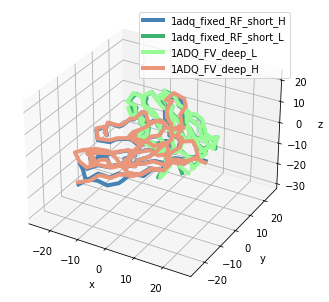

In [8]:
showProtein(ra_real, ra_predicted)
legend()

In [9]:
#matches = matchChains(ra_real, ra_predicted)
#for match in matches:
#    printMatch(match)

Benchmark evaluation
====================

In [10]:
benchmark_path = inputs / "antibodies_benchmark"
structures_path =  benchmark_path / "structures"

In [17]:
#tprint(structures_path)

In [12]:
import polars as pl
df = pl.read_csv(benchmark_path / "antibodies.tsv", sep="\t")

### Extracting antibodies

In [13]:
antibody_col = pl.col("Protein 1")
antibodies = df.filter(pl.col("Cat.").str.contains("AA"))
antibodies

Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD (Å),ΔASA(Å2),BM version introduced
str,str,str,str,str,str,f64,i64,f64
"""1AHW_AB:C""","""AA""","""1FGN_LH""","""Fab 5g9""","""1TFH_A""","""Tissue factor""",0.69,1899,2.0
"""1DQJ_AB:C""","""AA""","""1DQQ_CD""","""Fab Hyhel63""","""3LZT_""","""HEW lysozyme""",0.75,1765,2.0
"""1E6J_HL:P""","""AA""","""1E6O_HL""","""Fab""","""1A43_""","""HIV-1 capsid protein p24""",1.05,1245,2.0
"""1JPS_HL:T""","""AA""","""1JPT_HL""","""Fab D3H44""","""1TFH_B""","""Tissue factor""",0.51,1852,2.0
"""1MLC_AB:E""","""AA""","""1MLB_AB""","""Fab44.1""","""3LZT_""","""HEW lysozyme""",0.6,1392,2.0
"""1S78_DC:A""","""AA""","""1L7I_HL""","""pertuzumab (Perjeta)""","""2A91_A""","""ErbB2""",1.13,2175,5.5
"""1VFB_AB:C""","""AA""","""1VFA_AB""","""Fv D1.3""","""8LYZ_""","""HEW lysozyme""",1.02,1383,2.0
"""1WEJ_HL:F""","""AA""","""1QBL_HL""","""Fab E8""","""1HRC_""","""Cytochrome C""",0.31,1177,2.0
"""2FD6_HL:U""","""AA""","""2FAT_HL""","""Plasminogen receptor antibody""","""1YWH_A""","""Plasminogen activator receptor""",1.07,1139,3.0


In [99]:
def path_from_complex(s: str, antibody: bool = True, bound: bool = True) -> Path:
    return structures_path / (s[0:s.index("_")] + f"_{'r' if antibody else 'l'}" f"_{'b' if bound else 'u'}" + ".pdb")

def antibody_bound(row) -> str:
    return str(path_from_complex(row[0], True, True))

def antibody_unbound(row) -> str:
    return str(path_from_complex(row[0], True, False))

def antigen_bound(row) -> str:
    return str(path_from_complex(row[0], False, True))

def antigen_unbound(row) -> str:
    return str(path_from_complex(row[0], False, False))

In [100]:
def with_column(df: pl.DataFrame, name: str, fun: Callable) -> pl.DataFrame:
    series: pl.Series = df.apply(fun)["apply"]
    return df.with_column(series.rename(name))

def with_complex_column(df: pl.DataFrame, name: str, fun: Callable) -> pl.DataFrame:
    return with_column(df, name, lambda row: fun(row[0]))

In [114]:
def with_antigens(df: pl.DataFrame) -> pl.DataFrame:
    bound = with_column(df, "antigen_bound", antigen_bound)
    return with_column(bound, "antigen_unbound", antigen_unbound)

def with_antibodies(df: pl.DataFrame) -> pl.DataFrame:
    with_chains = with_complex_column(df,  "chains",  lambda s: s[s.index("_")+1:s.index(":")])
    with_bound = with_column(with_chains, "antibody_bound", antibody_bound)
    return with_column(with_bound, "antibody_unbound", antibody_unbound)

In [115]:
antibodies = with_antigens(with_antibodies( df.filter(pl.col("Cat.").str.contains("AA"))))
antibodies

Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD (Å),ΔASA(Å2),BM version introduced,chains,antibody_bound,antibody_unbound,antigen_bound,antigen_unbound
str,str,str,str,str,str,f64,i64,f64,str,str,str,str,str
"""1AHW_AB:C""","""AA""","""1FGN_LH""","""Fab 5g9""","""1TFH_A""","""Tissue factor""",0.69,1899,2.0,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1AHW_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1AHW_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1AHW_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1AHW_l_u.pdb"""
"""1DQJ_AB:C""","""AA""","""1DQQ_CD""","""Fab Hyhel63""","""3LZT_""","""HEW lysozyme""",0.75,1765,2.0,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1DQJ_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1DQJ_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1DQJ_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1DQJ_l_u.pdb"""
"""1E6J_HL:P""","""AA""","""1E6O_HL""","""Fab""","""1A43_""","""HIV-1 capsid protein p24""",1.05,1245,2.0,"""HL""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_l_u.pdb"""
"""1JPS_HL:T""","""AA""","""1JPT_HL""","""Fab D3H44""","""1TFH_B""","""Tissue factor""",0.51,1852,2.0,"""HL""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_l_u.pdb"""
"""1MLC_AB:E""","""AA""","""1MLB_AB""","""Fab44.1""","""3LZT_""","""HEW lysozyme""",0.6,1392,2.0,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1MLC_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1MLC_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1MLC_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1MLC_l_u.pdb"""
"""1S78_DC:A""","""AA""","""1L7I_HL""","""pertuzumab (Perjeta)""","""2A91_A""","""ErbB2""",1.13,2175,5.5,"""DC""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1S78_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1S78_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1S78_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1S78_l_u.pdb"""
"""1VFB_AB:C""","""AA""","""1VFA_AB""","""Fv D1.3""","""8LYZ_""","""HEW lysozyme""",1.02,1383,2.0,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_l_u.pdb"""
"""1WEJ_HL:F""","""AA""","""1QBL_HL""","""Fab E8""","""1HRC_""","""Cytochrome C""",0.31,1177,2.0,"""HL""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_l_u.pdb"""
"""2FD6_HL:U""","""AA""","""2FAT_HL""","""Plasminogen receptor antibody""","""1YWH_A"""

In [116]:
antibodies_HL = antibodies_extended[antibodies_extended["chains"] == "HL"]
antibodies_HL

Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD (Å),ΔASA(Å2),BM version introduced,antibody_bound,antibody_unbound,chains
str,str,str,str,str,str,f64,i64,f64,str,str,str
"""1E6J_HL:P""","""AA""","""1E6O_HL""","""Fab""","""1A43_""","""HIV-1 capsid protein p24""",1.05,1245,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_u.pdb""","""HL"""
"""1JPS_HL:T""","""AA""","""1JPT_HL""","""Fab D3H44""","""1TFH_B""","""Tissue factor""",0.51,1852,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_u.pdb""","""HL"""
"""1WEJ_HL:F""","""AA""","""1QBL_HL""","""Fab E8""","""1HRC_""","""Cytochrome C""",0.31,1177,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_u.pdb""","""HL"""
"""2FD6_HL:U""","""AA""","""2FAT_HL""","""Plasminogen receptor antibody""","""1YWH_A""","""Plasminogen activator receptor""",1.07,1139,3.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2FD6_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2FD6_r_u.pdb""","""HL"""
"""2VXT_HL:I ""","""AA""","""2VXU_HL""","""Murine reference antibody 125-2H FAB""","""1J0S_A(6)""","""Interleukin-18""",1.33,2163,5.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2VXT_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2VXT_r_u.pdb""","""HL"""
"""2W9E_HL:A ""","""AA""","""2W9D_HL""","""ICSM 18 FAB fragment""","""1QM1_A""","""Prion protein fragment""",1.13,1677,5.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2W9E_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/2W9E_r_u.pdb""","""HL"""
"""3MJ9_HL:A""","""AA""","""3MJ8_HL""","""HL4E10""","""3MJ6_A""","""JAML""",1.48,2457,5.5,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3MJ9_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3MJ9_r_u.pdb""","""HL"""
"""3SE8_HL:G""","""AA""","""5JXA_HL""","""VRC03""","""3TGT_A""","""HIV 93TH057 gp120""",1.22,2690,5.5,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3SE8_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3SE8_r_u.pdb""","""HL"""
"""3U7Y_HL:G""","""AA""","""3U7W_HL""","""NIH45-46""","""3TGT_A""","""HIV 93TH057 gp120""",0.84,2544,5.5,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3U7Y_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/3U7Y_r_u.pdb""","""HL"""


In [119]:
fabs = antibodies_HL.filter(antibody_col.str.contains("Fab"))
fabs

Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD (Å),ΔASA(Å2),BM version introduced,antibody_bound,antibody_unbound,chains
str,str,str,str,str,str,f64,i64,f64,str,str,str
"""1E6J_HL:P""","""AA""","""1E6O_HL""","""Fab""","""1A43_""","""HIV-1 capsid protein p24""",1.05,1245,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1E6J_r_u.pdb""","""HL"""
"""1JPS_HL:T""","""AA""","""1JPT_HL""","""Fab D3H44""","""1TFH_B""","""Tissue factor""",0.51,1852,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1JPS_r_u.pdb""","""HL"""
"""1WEJ_HL:F""","""AA""","""1QBL_HL""","""Fab E8""","""1HRC_""","""Cytochrome C""",0.31,1177,2.0,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1WEJ_r_u.pdb""","""HL"""
"""6B0S_HL:C""","""AA""","""6B0W_HL""","""1710 Fab fragment""","""3VDJ_A""","""circumsporozoite protein aTSR domain""",0.72,1353,5.5,"""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/6B0S_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/6B0S_r_u.pdb""","""HL"""


In [121]:
fvs = antibodies.filter(antibody_col.str.contains("Fv"))
fvs

Complex,Cat.,PDB ID 1,Protein 1,PDB ID 2,Protein 2,I-RMSD (Å),ΔASA(Å2),BM version introduced,chains,antibody_bound,antibody_unbound,antigen_bound,antigen_unbound
str,str,str,str,str,str,f64,i64,f64,str,str,str,str,str
"""1VFB_AB:C""","""AA""","""1VFA_AB""","""Fv D1.3""","""8LYZ_""","""HEW lysozyme""",1.02,1383,2.0,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/1VFB_l_u.pdb"""
"""5GRJ_HL:A""","""AA""","""4NKI_HL""","""avelumab scFv (Bavencio)""","""4Z18_A""","""PD-L1""",1.14,1753,5.5,"""HL""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5GRJ_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5GRJ_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5GRJ_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5GRJ_l_u.pdb"""
"""5CBA_AB:E""","""AA""","""5C2B_HL""","""3B4 scFv""","""4ZAI_A""","""CXCL13""",1.49,1790,5.5,"""AB""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5CBA_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5CBA_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5CBA_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5CBA_l_u.pdb"""
"""5KOV_C:AB""","""AA""","""5I30_HL""","""PL-2 scFv""","""5KOU_AB""","""astrovirus 2 capsid protein spike domain""",1.69,1735,5.5,"""C""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5KOV_r_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5KOV_r_u.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5KOV_l_b.pdb""","""/data/sources/antibody-mm/data/input/antibodies_benchmark/structures/5KOV_l_u.pdb"""


In [87]:
import shutil
output = Path("/data/samples/docking/benchmarks/selected")
for r in bound_receptors:
    shutil.copy(r, output / r.name)